# Preselection 

## Import libraries and choose whether to run locally or distributed

In [1]:
import ROOT
import os
from dask.distributed import Client
distributed = True
MT = False

Error in <TExMap::Add>: key 140167026998752 is not unique
Error in <TExMap::Add>: key 140167027515344 is not unique
TClassTable::Add:0: RuntimeWarning: class timespec already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<TString*,vector<TString> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<int*,vector<int> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<string*,vector<string> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<const char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<TString*,vector<TString> > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__no

Welcome to JupyROOT 6.25/01


In [2]:
if distributed != True and MT == True:
    ROOT.ROOT.EnableImplicitMT()

## Declare utils defined in a preselection.h file to the ROOT interpreter. If running distributed, connect to cluster and declare the file content in an initialization function

In [3]:
def my_initialization_function():
    ROOT.gInterpreter.Declare('{}'.format(data))

In [4]:
if distributed == True:
    RDataFrame = ROOT.RDF.Experimental.Distributed.Dask.RDataFrame
    sched_port = 24695
    client = Client(address="tcp://127.0.0.1:"+str(sched_port))
    text_file = open("preselection.h", "r")
    data = text_file.read()
    ROOT.RDF.Experimental.Distributed.initialize(my_initialization_function)

else:
    RDataFrame = ROOT.RDataFrame
    ROOT.gInterpreter.Declare('#include "preselection.h"')

/opt/conda/lib/python3.9/site-packages/distributed/client.py:1123: VersionMismatchWarning: Mismatched versions found

+-------------+-----------+-----------+-----------+
| Package     | client    | scheduler | workers   |
+-------------+-----------+-----------+-----------+
| dask        | 2021.09.1 | 2021.09.0 | 2021.09.0 |
| distributed | 2021.09.1 | 2021.09.0 | 2021.09.0 |
| numpy       | 1.20.3    | 1.21.2    | 1.21.2    |
| pandas      | 1.3.4     | 1.3.3     | 1.3.3     |
+-------------+-----------+-----------+-----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Loading histogram NUM_TightID_DEN_genTracks_eta_pt from file https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/leptonSF/Mu_RunBCDEFGH_SF_ID_2016_syst.root... 
Loading histogram EGamma_SF2D from file https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/leptonSF/EGM2D_RECO_SF_2016.root... 
Loading histogram EGamma_SF2D from file https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/leptonSF/2016LegacyReReco_ElectronMVA90noiso_Fall17V2.root... 
Loading histogram NUM_TightID_DEN_genTracks_pt_abseta from file https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/leptonSF/Muon_RunBCDEF_SF_ID_2017.root... 
Loading histogram NUM_TightRelIso_DEN_TightIDandIPCut_pt_abseta from file https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools/python/postprocessing/data/leptonSF/Muon_RunBCDEF_SF_ISO_2017.root... 
Loading histogram EGamma_SF2D from file https://ttedesch.web.cern.ch/ttedesch/nanoAOD-tools

## Define the dataframe starting from a chain of root files

In [5]:
proxy = "root://212.189.205.221:30443//root://xrootd-cms.infn.it/"
chain = [proxy + "/store/mc/RunIIFall17NanoAODv7/VBS_SSWW_LL_polarization_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/100000/5ADAED4E-FEEE-884F-8555-FF6FB31D6A60.root"]
#chain = ["RunIIFall17NanoAODv7-5ADAED4E-FEEE-884F-8555-FF6FB31D6A60.root"]


if distributed == True:
    df = RDataFrame("Events", chain, npartitions=4, daskclient=client)
else:
    df = RDataFrame("Events", chain)

## Define preselection flow

In [6]:
df_year = df.DefinePerSample("Year","GetYear(rdfslot_, rdfsampleinfo_)")

#### MET HLT Filter ####   #### working only for 2017 and 2018 (2016 requires a column that is not present in 2017 nd 2018, i.e. HLT_IsoTkMu24
df_METHLTFilter = df_year.Define("METHLTFilter", "MET_HLT_Filter(Year, Flag_goodVertices, Flag_HBHENoiseFilter, Flag_HBHENoiseIsoFilter, Flag_EcalDeadCellTriggerPrimitiveFilter, Flag_BadPFMuonFilter, Flag_globalSuperTightHalo2016Filter, HLT_Ele27_WPTight_Gsf,  HLT_Ele32_WPTight_Gsf, HLT_IsoMu24, HLT_IsoMu27, HLT_Mu50, HLT_Ele35_WPTight_Gsf, HLT_Ele32_WPTight_Gsf_L1DoubleEG, HLT_Photon200)")\
                         .Filter("METHLTFilter == true", "MET HLT Filter")

#### preselection #####
df_preselection = df_METHLTFilter.Filter("PV_ndof> 4 && abs(PV_z) < 20 && hypot(PV_x, PV_y)<2", "Good vertex")\
                                 .Define("HT_eventHT", "GetEventHT(Jet_pt, Jet_eta, Jet_phi, Jet_mass)")

#### lepSF #####
df_LepSF = df_preselection.Define("LepSF_output", "LepSF(Electron_pt, Electron_eta, Electron_pdgId, Muon_pt, Muon_eta, Muon_pdgId, Year)")\
                          .Define("Muon_effSF", "LepSF_output[0]")\
                          .Define("Electron_effSF", "LepSF_output[1]")\
                          .Define("Muon_effSF_errUp", "LepSF_output[2]")\
                          .Define("Electron_effSF_errUp", "LepSF_output[3]")\
                          .Define("Muon_effSF_errDown", "LepSF_output[4]")\
                          .Define("Electron_effSF_errDown", "LepSF_output[5]")

#### mht ####
df_mht = df_LepSF.Define("MHT_pt_phi", "MHT_pt_phi(Electron_pt, Electron_eta, Electron_phi, Electron_mass, Electron_miniPFRelIso_all, Muon_pt, Muon_eta, Muon_phi, Muon_mass, Muon_miniPFRelIso_all, Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_muonIdx1, Jet_muonIdx2, Jet_electronIdx1, Jet_electronIdx2, nJet)")\
                 .Define("MHT_pt", "MHT_pt_phi[0]").Define("MHT_phi", "MHT_pt_phi[1]")\

h = df_mht.Histo1D("Muon_effSF")

## Trigger event loop

/cvmfs/cms.dodas.infn.it/miniconda3/envs/cms-dodas/lib/root/DistRDF/Backends/Base.py:142: UserWarning: Number of partitions is greater than number of clusters in the dataset. Using 1 partition(s)
  ranges = headnode.build_ranges()


CPU times: user 1.71 s, sys: 396 ms, total: 2.11 s
Wall time: 22.7 s


Warning in <TClass::Init>: no dictionary for class edm::Hash<1> is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessHistory is available
Warning in <TClass::Init>: no dictionary for class edm::ProcessConfiguration is available
Warning in <TClass::Init>: no dictionary for class edm::ParameterSetBlob is available
Warning in <TClass::Init>: no dictionary for class pair<edm::Hash<1>,edm::ParameterSetBlob> is available


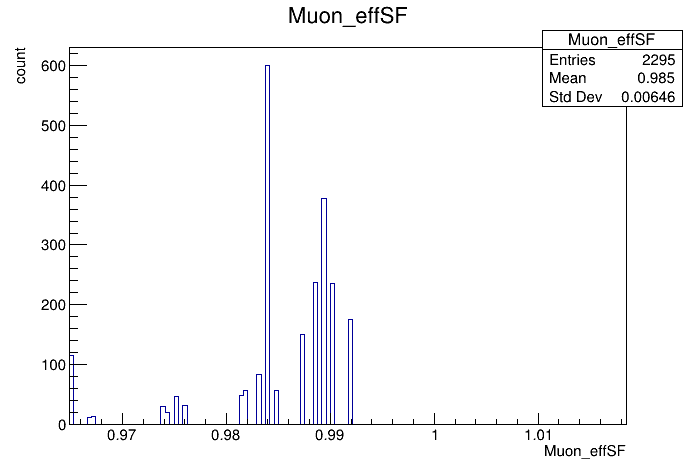

In [7]:
%%time
c = ROOT.TCanvas()
h.Draw()
c.Draw()